In [43]:
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          DataCollatorWithPadding, Trainer, TrainingArguments)
import numpy as np

from data import SharedTaskData


# Prepare dataset

In [44]:
train_data = SharedTaskData("TaskA_train.csv")
dev_data = SharedTaskData("TaskA_dev.csv")

train_dataset_novelty = train_data.convert_to_hf_dataset("novelty")
train_dataset_validity = train_data.convert_to_hf_dataset("validity")
# Use feature mapping from training dataset to ensure features are mapped correctly
dev_dataset_novelty = dev_data.convert_to_hf_dataset("novelty", features=train_dataset_novelty.features)
dev_dataset_validity = dev_data.convert_to_hf_dataset("validity", features=train_dataset_validity.features)

# Make sure internal label mapping is identical across datasets
assert train_dataset_validity.features['validity_str']._str2int == dev_dataset_validity.features['validity_str']._str2int
assert train_dataset_novelty.features['novelty_str']._str2int == dev_dataset_novelty.features['novelty_str']._str2int

Casting the dataset: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 481.77ba/s]


{'deafisible': 0, 'not-valid': 1, 'valid': 2}


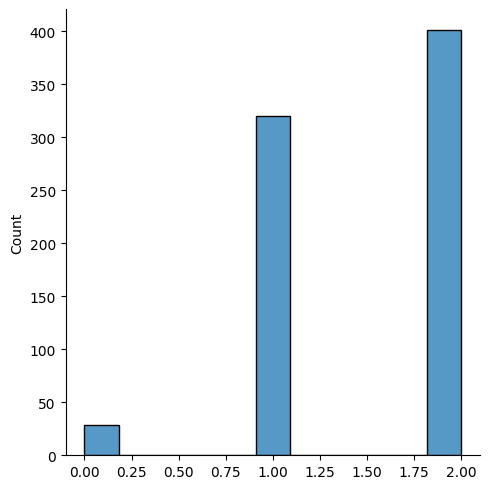

In [45]:
# investigate validity labels
print(train_dataset_validity.features['validity_str']._str2int)
sns.displot(train_dataset_validity['validity_str'])

{'borderline novel': 0, 'not-novel': 1, 'novel': 2}


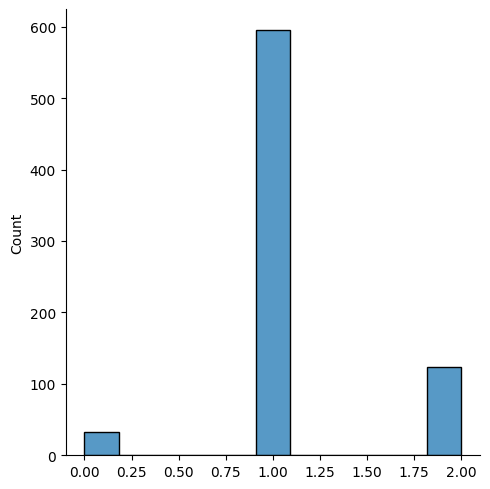

In [46]:
# .. and novelty labels
print(train_dataset_novelty.features['novelty_str']._str2int)
sns.displot(train_dataset_novelty['novelty_str'])

In [47]:
# Random Baseline novelty
print("Novelty")
y_true = np.array(dev_dataset_novelty['novelty_str'])
y_pred = np.random.randint(low=0, high=2, size=len(dev_dataset_novelty))
print(classification_report(y_true, y_pred))

# Random Baseline validity
print("Validity")
y_true = np.array(dev_dataset_validity['validity_str'])
y_pred = np.random.randint(low=0, high=2, size=len(dev_dataset_validity))
print(classification_report(y_true, y_pred))

# Majority Baseline novelty
print("Novelty")
y_true = np.array(dev_dataset_novelty['novelty_str'])
y_pred = np.array([train_dataset_novelty.features['novelty_str']._str2int['not-novel']] * len(dev_dataset_novelty))
print(classification_report(y_true, y_pred))

# Majority Baseline validity
print("Validity")
y_true = np.array(dev_dataset_validity['validity_str'])
y_pred = np.array([train_dataset_validity.features['validity_str']._str2int['valid']] * len(dev_dataset_validity))
print(classification_report(y_true, y_pred))

Novelty
              precision    recall  f1-score   support

           0       0.02      1.00      0.04         2
           1       0.57      0.49      0.53       118
           2       0.00      0.00      0.00        82

    accuracy                           0.30       202
   macro avg       0.20      0.50      0.19       202
weighted avg       0.34      0.30      0.31       202

Validity
              precision    recall  f1-score   support

           0       0.03      1.00      0.06         3
           1       0.36      0.50      0.42        74
           2       0.00      0.00      0.00       125

    accuracy                           0.20       202
   macro avg       0.13      0.50      0.16       202
weighted avg       0.13      0.20      0.15       202

Novelty
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.58      1.00      0.74       118
           2       0.00      0.00      0.00       

/home/m0re/projects/phd/venvs/vargmining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m0re/projects/phd/venvs/vargmining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m0re/projects/phd/venvs/vargmining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

# Data imbalance
We suffer from some data imbalance so we may need to oversample.

In [ ]:
# We focus on predicting Validity label for now
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    num_labels=train_dataset_validity.features['validity_str'].num_classes,
    label2id=train_dataset_validity.features['validity_str']._str2int, 
    id2label={v:k for k, v in train_dataset_validity.features['validity_str']._str2int.items()},
)


def tokenize_function(examples):
    batch_size = len(examples['Premise'])
    batched_inputs = [
        examples['topic'][i] + tokenizer.sep_token + \
        examples['Premise'][i] + tokenizer.sep_token + \
        examples['Conclusion'][i] for i in range(batch_size)
    ]
    samples = tokenizer(batched_inputs, truncation=True, padding=True)
    samples['labels'] = examples['validity_str']
    return samples 

tokenized_train_dataset_validity = train_dataset_validity.map(tokenize_function, batched=True)
tokenized_dev_dataset_validity = dev_dataset_validity.map(tokenize_function, batched=True)
tokenized_train_dataset_validity.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tokenized_dev_dataset_validity.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [ ]:
# define metrics

def single_label_metrics(predictions, labels):
    softmax = torch.nn.Softmax(dim=1)
    preds = torch.Tensor(predictions)
    probs = softmax(preds)
    y_pred = torch.argmax(probs, dim=1)
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    return {'f1': f1_micro_average, 'accuracy': accuracy}

def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    return single_label_metrics(
        predictions=preds, 
        labels=p.label_ids
    )

In [ ]:
training_args = TrainingArguments(
    "argmining2022_trainer",
    num_train_epochs=10,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset_validity,
    eval_dataset=tokenized_dev_dataset_validity,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

# Multi-Task Learning
Code inspired by [here](https://colab.research.google.com/github/zphang/zphang.github.io/blob/master/files/notebooks/Multi_task_Training_with_Transformers_NLP.ipynb#scrollTo=yrtS3ZeSsoZw).


In [ ]:
from models import MultitaskModel
import transformers

In [ ]:
model_name = "roberta-base"
multitask_model = MultitaskModel.create(
    model_name=model_name,
    model_type_dict={
        "novelty": transformers.AutoModelForSequenceClassification,
        "validity": transformers.AutoModelForSequenceClassification,
    },
    model_config_dict={
        "novelty": transformers.AutoConfig.from_pretrained(model_name, num_labels=2),
        "validity": transformers.AutoConfig.from_pretrained(model_name, num_labels=2),
    },
)

if model_name.startswith("roberta-"):
    print(multitask_model.encoder.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict["novelty"].roberta.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict["validity"].roberta.embeddings.word_embeddings.weight.data_ptr())
else:
    print("Exercise for the reader: add a check for other model architectures =)")